## Merging of Per-Core Logs
### Can we assume the following about per-core behavior: 
#### If all cores of a running experiment do similar work, then their individual behaviors - as exposed by their per-core logs - are similar to each other, and hence, the behavior of all cores can be merged into an overall behavior of the full experimental run.

In [48]:
import os
import time
import pandas as pd
import numpy as np

In [49]:
import eigen_analysis

cols = eigen_analysis.LINUX_COLS
time_unit = eigen_analysis.TIME_CONVERSION_khz
joules_unit = eigen_analysis.JOULE_CONVERSION

In [50]:
# get all itrs explored for some (dvfs, qps) pair
def list_itrs(rdtsc_dirname):
    itrs = []
    for file in os.listdir(rdtsc_dirname):
        tags = file.split('_')
        itr = tags[1]
        itrs.append(itr)
    itrs = list(set(itrs))
    return itrs

In [51]:
global itrs

In [52]:
def print_err_log(dvfs, qps, itr, rapl='135', run='0', err_dir = 'err_logs/'):
    err_filename = 'err_log_' + run + '_' + itr + '_' + dvfs + '_' + rapl + '_' + qps[:-1] + '000'
    if os.path.exists(err_dir + err_filename):
        err_file = open(err_dir + err_filename, 'r')
        print(err_file.read())
    else:
        print('EMPTY ERROR LOG')

In [53]:
def handle_neg_diffs(df_diffs, df, core, err_file):
    
    tmp = df_diffs.copy()

    # isolating rows with negative diffs
    tmp_neg = tmp[(tmp['joules_diff'] < 0) | (tmp['instructions_diff'] < 0) | (tmp['cycles_diff'] < 0) \
                   | (tmp['ref_cycles_diff'] < 0) | (tmp['llc_miss_diff'] < 0) | (tmp['timestamp_diff'] < 0)]

    # re-computing diffs if possible; else dropping rows
    for i,j in tmp_neg.iterrows():
        prev = df.shift(1).loc[i]
        cur = df.loc[i]
        # TODO note that we are only handling case of RAPL-energy-status register overflow
        if (tmp.loc[i]['joules_diff'] < 0) & (tmp.loc[i]['timestamp_diff'] >= 0.001):
            err_file.write('CORE ' + str(core) + '  ---  JOULES COUNTER OVERFLOW AT LOG ENTRY DIFF #' + str(i) + '\n')
            tmp.loc[i, ['joules_diff']] = (2**32 - 1) * joules_unit - prev['joules'] + cur['joules'] 
        else:
            err_file.write('CORE ' + str(core) + '  ---  UNEXPLAINED NEGATIVE VALS AT LOG ENTRY DIFF # ' + str(i) + '\n')
            cols = ''
            prevs = ''
            currs = ''
            for col in list(df.columns):
                cols += col + '  '
                prevs += str(prev[col]) + '  '
                currs += str(cur[col]) + '  '
            err_file.write('          ' + cols + '\n')
            err_file.write('         log[' + str(i-1) + ']: ' + prevs + '\n')
            err_file.write('         log[' + str(i) + ']: ' + currs + '\n')
            tmp = tmp.drop(i, axis=0)

    return tmp

In [65]:
# given (dvfs, qps, itr), concatenate all per-core logs into one big dataframe
def concat_core_logs(dvfs, qps, itr, rapl='135', run='0'):
    print('Concatenating all per-core logs with ITR-DELAY = ', itr)
    
    # here are all the log files for this dvfs & qps
    logs_dir = qps + '_qps/linux_mcd_dmesg_' + run + '_' + dvfs + '_' + rapl + '_' + qps + '/'
    # here are all the time-management files for this dvfs & qps
    rdtsc_dir = qps + '_qps/linux_mcd_rdtsc_' + run + '_' + dvfs + '_' + rapl + '_' + qps +'/'
    rdtsc_file = rdtsc_dir + 'linux.mcd.rdtsc.' + run + '_' + itr + '_' + dvfs + '_' + rapl + '_' + qps[:-1] + '000'
    start, end = eigen_analysis.get_rdtsc(rdtsc_file)
        
    # initializing error log file
    err_dir = 'err_logs/'
    err_filename = 'err_log_' + run + '_' + itr + '_' + dvfs + '_' + rapl + '_' + qps[:-1] + '000'
    err_file = open(err_dir + err_filename, 'w')

    # here will be stored counter-based log data from all cores
    counters_full_df = pd.DataFrame()
    # here will be stored non-counter-based log data from all cores
    non_counters_full_df = pd.DataFrame()
    
    # TODO remove fixed core-id range
    for c in range(0,16):
        file = logs_dir + 'linux.mcd.dmesg.' + run + '_' + str(c) + '_' + itr + '_' + dvfs + '_' + rapl + '_' + qps[:-1] + '000'
        df = pd.read_csv(file, sep = ' ', names = cols, index_col='i')
        df = df[(df['timestamp'] >= start) & (df['timestamp'] <= end)]
        df['timestamp'] = df['timestamp'] - df['timestamp'].min()
        df['timestamp'] = df['timestamp'] * time_unit
        df['joules'] = df['joules'] * joules_unit

        # CONCATENATING MILLISECOND-LEVEL PER-CORE DFS
        ##############################################
        # removing zero-filled log-entries
        # -> these represent interrupt occurrences at a frequency greater than per-1ms
        counters_df = df[['joules', 'instructions', 'cycles', 'ref_cycles', 'llc_miss', 'timestamp']].copy()
        counters_df = counters_df[(counters_df['joules'] > 0) & (counters_df['instructions'] > 0) \
                                            & (counters_df['cycles'] > 0) & (counters_df['ref_cycles'] > 0) \
                                            & (counters_df['llc_miss'] > 0)]
        # SCHEME 2
        tmp = counters_df['timestamp']
        
        # computing diffs of counter readings
        df_diffs = counters_df.diff().dropna().copy()
        df_diffs.columns = [f'{c}_diff' for c in df_diffs.columns]
        df_diffs = handle_neg_diffs(df_diffs, counters_df, c, err_file)

        # SCHEME 1: merge per-core logs on index i where
        #           i = order of occurrence of a log-entry in a per-core log
#        df_diffs = df_diffs.drop(['timestamp_diff'], axis=1).reset_index()
#        if counters_full_df.shape[0] == 0:
#            counters_full_df = df_diffs.copy()
#        else:
#            counters_full_df = counters_full_df.merge(df_diffs, left_index=True, right_index=True, \
#                                                      how='outer', sort=True, suffixes=('', '_0')).fillna(0)
        
        # SCHEME 2
        df_diffs = df_diffs.drop(['timestamp_diff'], axis=1)
        df_diffs['timestamp'] = tmp
        if counters_full_df.shape[0] == 0:
            counters_full_df = df_diffs.copy()
        else:
            counters_full_df = counters_full_df.merge(df_diffs, \
                                                      left_on = 'timestamp', \
                                                      right_on = 'timestamp', \
                                                      how='outer', \
                                                      sort=True, \
                                                      suffixes=('', '_0')).fillna(0)        

        # CONCATENATING MICROSECOND-LEVEL PER-CORE DFS
        ##############################################
        non_counters_df = df[['rx_bytes', 'rx_desc', 'tx_bytes', 'tx_desc']].copy()

        # SCHEME 1
#        if non_counters_full_df.shape[0] == 0:
#            non_counters_full_df = non_counters_df.copy()
#        else:
#            non_counters_full_df = non_counters_full_df.merge(non_counters_df, left_index=True, right_index=True, \
#                                                              how='outer', sort=True, suffixes=('', '_0')).fillna(0)
        print('CORE: ', str(c))
#        print('         NON COUNTERS:  full =', non_counters_df.shape[0], \
#              '  expected:', int(20 * 10**6 / int(itr)))        
        print('         COUNTERS:      full =', counters_df.shape[0], \
              '  after computing diffs =', df_diffs.shape[0])   
        

        

    # delete error log if empty
    err_file.close()
    if (os.path.getsize(err_dir + err_filename) == 0):
        os.remove(err_dir + err_filename)
        
    print()
    print('-------------------------------------------------- PARSED 16 LOGS -------------------------')
    print()
    return counters_full_df, non_counters_full_df

In [70]:
def merge_concat_logs(counters_full_df, non_counters_full_df):
    
    # creating dfs of average per-core log readings
    df_merged_counter = pd.DataFrame(columns=['instructions_diff', 'cycles_diff', 'ref_cycles_diff', \
                                     'llc_miss_diff', 'joules_diff'])
    df_merged_non_counter = pd.DataFrame()
#    df_merged_non_counter = pd.DataFrame(columns=['rx_bytes', 'rx_desc', 'tx_bytes', 'tx_desc'])

    # SCHEME 1
#    for col in df_merged_counter.columns:
#        df_merged_counter[col] = (counters_full_df[[col, col+'_0']].sum(axis=1))/16
#    for col in df_merged_non_counter.columns:
#        df_merged_non_counter[col] = (non_counters_full_df[[col, col+'_0']].sum(axis=1))/16

    # SCHEME 2
    for col in df_merged_counter.columns:
        df_merged_counter[col] = (counters_full_df[[col, col+'_0']].sum(axis=1))
    df_merged_counter['timestamp'] = counters_full_df['timestamp']
    
    return df_merged_counter, df_merged_non_counter

In [63]:
def save_merged_logs(merged_counters_df, merged_non_counters_df, dvfs, qps, itr, rapl='135', run='0'):
    
    counters_df_outdir = qps + '_' + dvfs + '_counters_merged/'
    non_counters_df_outdir = qps + '_' + dvfs + '_non_counters_merged/'
    !mkdir -p $counters_df_outdir
    !mkdir -p $non_counters_df_outdir
    counters_outfile = counters_df_outdir + dvfs + '_' + qps + '_' + itr + '_counters_merged'
    non_counters_outfile = non_counters_df_outdir + dvfs + '_' + qps + '_' + itr + '_non_counters_merged'
    merged_counters_df.to_csv(counters_outfile)
    merged_non_counters_df.to_csv(non_counters_outfile)

    print('COUNTERS DIR: ')
    !ls $counters_df_outdir
    print('NON_COUNTERS DIR: ')
    !ls $non_counters_df_outdir

In [71]:
dvfs = '0xd00'
qps = '400k'
run = '0'
rapl = '135'
itrs = list_itrs(qps + '_qps/linux_mcd_rdtsc_' + run + '_' + dvfs + '_' + rapl + '_' + qps +'/')
#for itr in itrs:
for itr in ['100']:
    counters_full_df = pd.DataFrame()
    non_counters_full_df = pd.DataFrame()
    counters_full_df, non_counters_full_df = concat_core_logs(dvfs, qps, itr)
    #print_err_log(dvfs, qps, itr)
    merged_counters_df, merged_non_counters_df = merge_concat_logs(counters_full_df, non_counters_full_df)
    #save_merged_logs(merged_counters_df, merged_non_counters_df, dvfs, qps, itr)
    print('----------------------------------------')

Concatenating all per-core logs with ITR-DELAY =  100
CORE:  0
         COUNTERS:      full = 19491   after computing diffs = 19490
CORE:  1
         COUNTERS:      full = 19492   after computing diffs = 19491
CORE:  2
         COUNTERS:      full = 19493   after computing diffs = 19492
CORE:  3
         COUNTERS:      full = 19492   after computing diffs = 19491
CORE:  4
         COUNTERS:      full = 19499   after computing diffs = 19498
CORE:  5
         COUNTERS:      full = 19490   after computing diffs = 19489
CORE:  6
         COUNTERS:      full = 19496   after computing diffs = 19495
CORE:  7
         COUNTERS:      full = 19496   after computing diffs = 19495
CORE:  8
         COUNTERS:      full = 19503   after computing diffs = 19502
CORE:  9
         COUNTERS:      full = 19494   after computing diffs = 19493
CORE:  10
         COUNTERS:      full = 19494   after computing diffs = 19493
CORE:  11
         COUNTERS:      full = 19493   after computing diffs = 19492
CORE:  1

In [72]:
counters_full_df

,joules_diff,instructions_diff,cycles_diff,ref_cycles_diff,llc_miss_diff,timestamp,joules_diff_0,instructions_diff_0,cycles_diff_0,ref_cycles_diff_0,...,joules_diff_0,instructions_diff_0,cycles_diff_0,ref_cycles_diff_0,llc_miss_diff_0,joules_diff_0,instructions_diff_0,cycles_diff_0,ref_cycles_diff_0,llc_miss_diff_0
0,0.0,0.0,0.0,0.0,0.0,0.001005,0.00000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.001006,0.00000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.001016,0.00000,0.0,0.0,0.0,...,0.091195,695567.0,1301639.0,2915660.0,4139.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.001017,0.00000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.001022,0.00000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311896,0.0,0.0,0.0,0.0,0.0,20.004383,0.00000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
311897,0.0,0.0,0.0,0.0,0.0,20.004385,0.00000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
311898,0.0,0.0,0.0,0.0,0.0,20.004475,0.00000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
311899,0.0,0.0,0.0,0.0,0.0,20.004586,0.00000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.108336,196529.0,414842.0,925912.0,1201.0


In [73]:
merged_counters_df

,instructions_diff,cycles_diff,ref_cycles_diff,llc_miss_diff,joules_diff,timestamp
0,573693.0,1222179.0,2740442.0,3412.0,0.091195,0.001005
1,655867.0,1288672.0,2880744.0,3591.0,0.082777,0.001006
2,695567.0,1301639.0,2915660.0,4139.0,0.091195,0.001016
3,607401.0,1219042.0,2735773.0,3720.0,0.091195,0.001017
4,655023.0,1236151.0,2771965.0,3960.0,0.091195,0.001022
...,...,...,...,...,...,...
311896,259462.0,544929.0,1215622.0,1812.0,0.126514,20.004383
311897,269754.0,550023.0,1226932.0,1637.0,0.112057,20.004385
311898,278054.0,608827.0,1358563.0,2217.0,0.234850,20.004475
311899,196529.0,414842.0,925912.0,1201.0,0.108336,20.004586


In [76]:
corr_dict = {}

# here are all the log files for this dvfs & qps
logs_dir = qps + '_qps/linux_mcd_dmesg_' + run + '_' + dvfs + '_' + rapl + '_' + qps + '/'
# here are all the time-management files for this dvfs & qps
rdtsc_dir = qps + '_qps/linux_mcd_rdtsc_' + run + '_' + dvfs + '_' + rapl + '_' + qps +'/'
rdtsc_file = rdtsc_dir + 'linux.mcd.rdtsc.' + run + '_' + itr + '_' + dvfs + '_' + rapl + '_' + qps[:-1] + '000'
start, end = eigen_analysis.get_rdtsc(rdtsc_file)

# initializing error log file
err_dir = 'err_logs/'
err_filename = 'err_log_' + run + '_' + itr + '_' + dvfs + '_' + rapl + '_' + qps[:-1] + '000'
err_file = open(err_dir + err_filename, 'w')

# TODO remove fixed core-id range
for c in range(0,16):
    file = logs_dir + 'linux.mcd.dmesg.' + run + '_' + str(c) + '_' + itr + '_' + dvfs + '_' + rapl + '_' + qps[:-1] + '000'
    df = pd.read_csv(file, sep = ' ', names = cols, index_col='i')
    df = df[(df['timestamp'] >= start) & (df['timestamp'] <= end)]
    df['timestamp'] = df['timestamp'] - df['timestamp'].min()
    df['timestamp'] = df['timestamp'] * time_unit
    df['joules'] = df['joules'] * joules_unit
    counters_df = df[['joules', 'instructions', 'cycles', 'ref_cycles', 'llc_miss', 'timestamp']].copy()
    counters_df = counters_df[(counters_df['joules'] > 0) & (counters_df['instructions'] > 0) \
                                        & (counters_df['cycles'] > 0) & (counters_df['ref_cycles'] > 0) \
                                        & (counters_df['llc_miss'] > 0)]
    # computing diffs of counter readings
    df_diffs = counters_df.diff().dropna().copy()
    df_diffs.columns = [f'{c}_diff' for c in df_diffs.columns]
    df_diffs = handle_neg_diffs(df_diffs, counters_df, c, err_file)
    df_corr = df_diffs.drop(['timestamp_diff'], axis = 1).corr()
    corr_dict[str(c)] = df_corr

In [77]:
corr_dict['0']

,joules_diff,instructions_diff,cycles_diff,ref_cycles_diff,llc_miss_diff
joules_diff,1.000000,0.037138,0.037152,0.037148,0.037775
instructions_diff,0.037138,1.000000,0.837637,0.837618,0.562625
cycles_diff,0.037152,0.837637,1.000000,1.000000,0.723921
ref_cycles_diff,0.037148,0.837618,1.000000,1.000000,0.723918
llc_miss_diff,0.037775,0.562625,0.723921,0.723918,1.000000


In [78]:
corr_dict['1']

,joules_diff,instructions_diff,cycles_diff,ref_cycles_diff,llc_miss_diff
joules_diff,1.000000,0.025029,0.021589,0.021584,0.024358
instructions_diff,0.025029,1.000000,0.809456,0.809430,0.547044
cycles_diff,0.021589,0.809456,1.000000,1.000000,0.695542
ref_cycles_diff,0.021584,0.809430,1.000000,1.000000,0.695545
llc_miss_diff,0.024358,0.547044,0.695542,0.695545,1.000000


In [79]:
corr_dict['2']

,joules_diff,instructions_diff,cycles_diff,ref_cycles_diff,llc_miss_diff
joules_diff,1.000000,0.027953,0.026734,0.026733,0.026345
instructions_diff,0.027953,1.000000,0.856367,0.856342,0.565736
cycles_diff,0.026734,0.856367,1.000000,1.000000,0.724280
ref_cycles_diff,0.026733,0.856342,1.000000,1.000000,0.724281
llc_miss_diff,0.026345,0.565736,0.724280,0.724281,1.000000


In [80]:
corr_dict['3']

,joules_diff,instructions_diff,cycles_diff,ref_cycles_diff,llc_miss_diff
joules_diff,1.000000,0.038104,0.033164,0.033162,0.030117
instructions_diff,0.038104,1.000000,0.821805,0.821778,0.542671
cycles_diff,0.033164,0.821805,1.000000,1.000000,0.694624
ref_cycles_diff,0.033162,0.821778,1.000000,1.000000,0.694624
llc_miss_diff,0.030117,0.542671,0.694624,0.694624,1.000000


In [81]:
corr_dict['4']

,joules_diff,instructions_diff,cycles_diff,ref_cycles_diff,llc_miss_diff
joules_diff,1.000000,0.032950,0.033087,0.033084,0.031973
instructions_diff,0.032950,1.000000,0.848527,0.848505,0.555047
cycles_diff,0.033087,0.848527,1.000000,1.000000,0.715816
ref_cycles_diff,0.033084,0.848505,1.000000,1.000000,0.715815
llc_miss_diff,0.031973,0.555047,0.715816,0.715815,1.000000


In [82]:
corr_dict['5']

,joules_diff,instructions_diff,cycles_diff,ref_cycles_diff,llc_miss_diff
joules_diff,1.000000,0.031379,0.029768,0.029767,0.028870
instructions_diff,0.031379,1.000000,0.814643,0.814612,0.571656
cycles_diff,0.029768,0.814643,1.000000,1.000000,0.716011
ref_cycles_diff,0.029767,0.814612,1.000000,1.000000,0.716005
llc_miss_diff,0.028870,0.571656,0.716011,0.716005,1.000000


In [83]:
corr_dict['6']

,joules_diff,instructions_diff,cycles_diff,ref_cycles_diff,llc_miss_diff
joules_diff,1.000000,0.017185,0.028347,0.028343,0.026894
instructions_diff,0.017185,1.000000,0.831559,0.831538,0.543977
cycles_diff,0.028347,0.831559,1.000000,1.000000,0.707081
ref_cycles_diff,0.028343,0.831538,1.000000,1.000000,0.707085
llc_miss_diff,0.026894,0.543977,0.707081,0.707085,1.000000


In [84]:
corr_dict['7']

,joules_diff,instructions_diff,cycles_diff,ref_cycles_diff,llc_miss_diff
joules_diff,1.000000,0.014800,0.016676,0.016671,0.022358
instructions_diff,0.014800,1.000000,0.835765,0.835732,0.568634
cycles_diff,0.016676,0.835765,1.000000,1.000000,0.714992
ref_cycles_diff,0.016671,0.835732,1.000000,1.000000,0.714991
llc_miss_diff,0.022358,0.568634,0.714992,0.714991,1.000000


In [74]:
merged_counters_df.drop(['timestamp'], axis = 1).corr()

,instructions_diff,cycles_diff,ref_cycles_diff,llc_miss_diff,joules_diff
instructions_diff,1.000000,0.829299,0.829274,0.554843,0.028141
cycles_diff,0.829299,1.000000,1.000000,0.705522,0.029668
ref_cycles_diff,0.829274,1.000000,1.000000,0.705523,0.029666
llc_miss_diff,0.554843,0.705522,0.705523,1.000000,0.028272
joules_diff,0.028141,0.029668,0.029666,0.028272,1.000000


In [133]:
from numpy.linalg import eig, eigvalsh

all_vals = {}
for c in range(0,16):
    vals, vecs = eig(corr_dict[str(c)])
    all_vals[str(c)] = vals
merged_corr = merged_counters_df.drop(['timestamp'], axis = 1).corr()
merged_vals, merged_vecs = eig(merged_corr)
all_vals['merged'] = merged_vals

In [134]:
list(all_vals.values())[0]

array([3.36295754e+00, 9.97716818e-01, 4.56869175e-01, 1.82456233e-01,
       2.32642738e-07])

In [138]:
import matplotlib.pyplot as plt

def plot_eig_vals(eig_dict):
    plt.figure(figsize=(6,6))
    num_eig = len(list(eig_dict.values())[0])
    eig_list = [str(i) for i in range(0, num_eig)]
    for core in eig_dict.keys():
        vals = eig_dict[core]
        #print(vals)
        plt.plot(eig_list, vals, 'p')
    plt.plot(eig_list, eig_dict['merged'], 'x')    
    plt.xlabel('eig_id')
    plt.ylabel('eig_val')
    plt.title(f'Eigenvals of Corr Matrices of {len(eig_dict.keys())} mcd Cores')

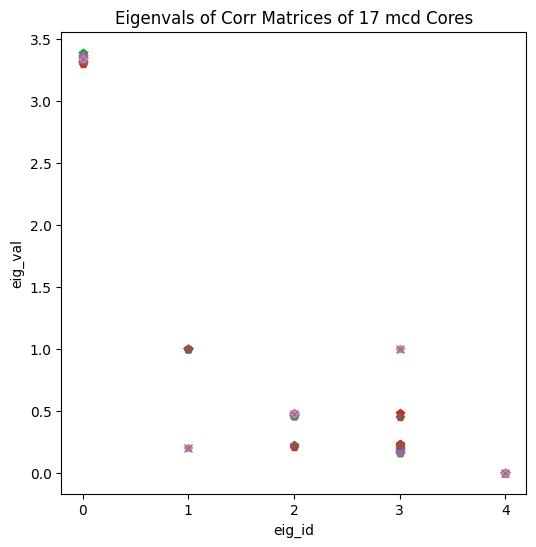

In [139]:
plot_eig_vals(all_vals)

In [103]:
non_counters_full_df

,rx_bytes,rx_desc,tx_bytes,tx_desc,rx_bytes_0,rx_desc_0,tx_bytes_0,tx_desc_0,rx_bytes_0,rx_desc_0,...,tx_bytes_0,tx_desc_0,rx_bytes_0,rx_desc_0,tx_bytes_0,tx_desc_0,rx_bytes_0,rx_desc_0,tx_bytes_0,tx_desc_0
i,,,,,,,,,,,,,,,,,,,,,
107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,66,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,132,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,66,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
584805,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,132,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
584806,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,66,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [108]:
merged_counters_df

,instructions_diff,cycles_diff,ref_cycles_diff,llc_miss_diff,joules_diff
0,676844.2500,1.278246e+06,2.855681e+06,3953.6875,0.104779
1,695104.3750,1.266143e+06,2.824477e+06,3805.1250,0.134848
2,716595.0000,1.298005e+06,2.895565e+06,3732.4375,0.133331
3,708744.3125,1.256791e+06,2.803615e+06,3290.5625,0.133567
4,717205.3750,1.263793e+06,2.819248e+06,3375.3125,0.132824
...,...,...,...,...,...
19447,159059.2500,3.476983e+05,7.756376e+05,850.7500,0.031930
19448,138686.7500,2.898031e+05,6.464916e+05,690.3750,0.039132
19449,43147.0625,9.407319e+04,2.098458e+05,178.5000,0.014709
19450,38942.1875,7.963438e+04,1.776486e+05,190.1875,0.008212


In [102]:
merged_non_counters_df

,rx_bytes,rx_desc,tx_bytes,tx_desc
i,,,,
107,8.2500,0.1250,0.000,0.000
108,7.3750,0.0625,0.000,0.000
109,20.7500,0.1250,4.125,0.125
110,0.0000,0.0000,8.250,0.250
111,15.1875,0.1250,0.000,0.000
...,...,...,...,...
584804,0.0000,0.0000,4.125,0.125
584805,0.0000,0.0000,8.250,0.250
584806,0.0000,0.0000,4.125,0.125
